In [ ]:
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score, accuracy_score, matthews_corrcoef, \
    cohen_kappa_score
from imblearn.metrics import geometric_mean_score


def evaluate_result(y_true, y_prediction, prob):
    f1_weighted = f1_score(y_true, y_prediction, average='weighted')
    f1_per_class = f1_score(y_true, y_prediction, average=None).tolist()
    accuracy = accuracy_score(y_true, y_prediction)
    precision = precision_score(y_true, y_prediction, average='weighted')
    recall = recall_score(y_true, y_prediction, average='weighted')
    if prob is not None:
        roc_uac = roc_auc_score(y_true, prob, average='weighted', multi_class='ovo')
    else:
        roc_uac = 0
    mcc = matthews_corrcoef(y_true, y_prediction)
    kappa_score = cohen_kappa_score(y_true, y_prediction)
    gmean = geometric_mean_score(y_true, y_prediction, average='weighted')

    eval_result = {
        "eval_f1": float(f1_weighted),
        "eval_f1_class1": float(f1_per_class[0]),
        "eval_f1_class2": float(f1_per_class[1]),
        "eval_f1_class3": float(f1_per_class[2]),
        "eval_f1_class4": float(f1_per_class[3]),
        "eval_acc": float(accuracy),
        "eval_precision": float(precision),
        "eval_recall": float(recall),
        "eval_ROC-UAC": float(roc_uac),
        "eval_mcc": float(mcc),
        "eval_cohen_kappa_score": float(kappa_score),
        "eval_gmean": float(gmean)
    }
    return eval_result


In [ ]:
DATA = "/content/drive/MyDrive/SW -FL: EASE 2025/colab-notebooklar/datasets"

In [ ]:
!pip install sdv ctgan

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 156.5/156.5 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.6/139.6 kB 16.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.4/13.4 MB 99.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.5/52.5 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.5/68.5 kB 8.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 187.6/187.6 kB 19.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 93.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 71.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 57.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sdv.metadata import SingleTableMetadata
from sdv.single_table import GaussianCopulaSynthesizer, CTGANSynthesizer, TVAESynthesizer, CopulaGANSynthesizer
from xgboost import XGBClassifier
from sklearn.preprocessing import RobustScaler
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import StratifiedKFold
from sdv.evaluation.multi_table import run_diagnostic, evaluate_quality
from sdv.evaluation.multi_table import get_column_plot
from sklearn.metrics import classification_report, accuracy_score
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.svm import LinearSVC
import os

os.makedirs("results", exist_ok=True)

In [ ]:
def plot_label(df):
  class_counts = df['label'].value_counts()

  # Görselleştirme
  plt.figure(figsize=(8, 5))
  plt.bar(class_counts.index, class_counts.values, color='skyblue')
  plt.xlabel("Label Classes")
  plt.ylabel("Count")
  plt.title("Class Distribution")
  plt.grid(axis='y', linestyle='--', alpha=0.7)
  plt.show()
  print(class_counts)


In [ ]:
train = pd.read_csv(fr"{DATA}/data/train.csv")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


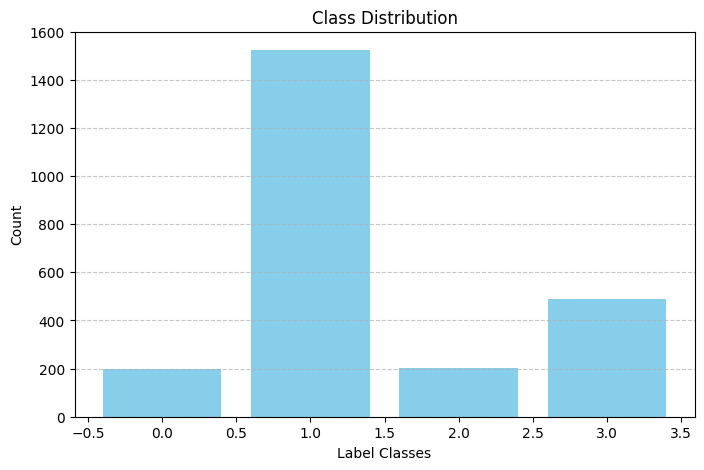

label
1    1524
3     489
2     203
0     198
Name: count, dtype: int64


In [ ]:
plot_label(train)

In [ ]:
test = pd.read_csv(fr"{DATA}/data/test.csv")

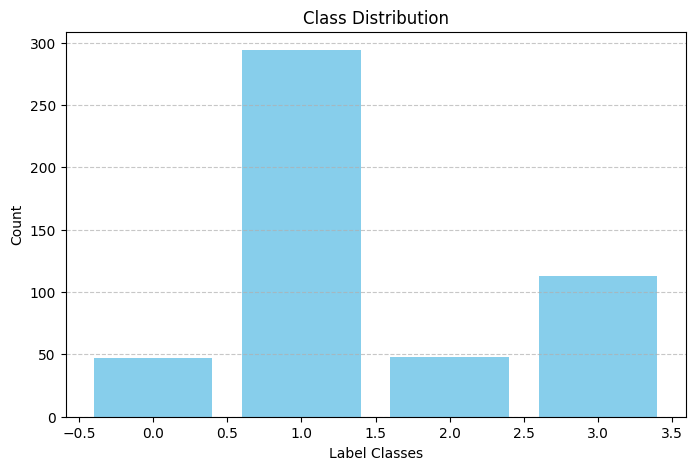

label
1    294
3    113
2     48
0     47
Name: count, dtype: int64


In [ ]:
plot_label(test)

In [ ]:
TRAIN_COLS = ['lc', 'pi', 'ma', 'nbd', 'ml', 'd', 'mi', 'fo', 'r', 'e']
train = train[TRAIN_COLS + ["label"]]
test = test[TRAIN_COLS + ["label"]]

x_train = train.drop(columns=["label"])
y_train = train["label"]

x_test = test.drop(columns=["label"])
y_test = test["label"]

In [ ]:
classifiers = {
    "SVM": LinearSVC(
        penalty="l2",
        loss="squared_hinge",
        dual=True,
        C=0.5,
        class_weight="balanced",
        max_iter=5000,
        tol=1e-4,
        random_state=42
    ),
    "XGBoost": XGBClassifier(objective="multi:softprob",
                             num_class=4,
                             eval_metric="mlogloss",
                             num_parallel_tree=None,
                             n_estimators=200,
                             tree_method="hist",
                             random_state=42, ),
    "PassiveAggressive": PassiveAggressiveClassifier(C=1.0,
                                                     max_iter=1000,
                                                     loss="hinge",
                                                     tol=1e-3,
                                                     random_state=50),
}

In [ ]:
generators = {
    "GaussianCopula": GaussianCopulaSynthesizer,
    "CTGAN": CTGANSynthesizer,
    #"TVAE": TVAESynthesizer,
    # "CopulaGAN": CopulaGANSynthesizer
}

model_name = "XGBoost"
model_selected = classifiers[model_name]

# Metadata
metadata = SingleTableMetadata()
metadata.detect_from_dataframe(train)
metadata.update_column(column_name='label', sdtype='categorical')

results = []

# Tüm yöntemleri uygula
for name, Synthesizer in generators.items():
    print(f"--- {name} ile veri üretiliyor ---")

    # Sentetik veri üretimi
    try:
      synthesizer = Synthesizer(metadata, epochs=1500)
    except:
      synthesizer = Synthesizer(metadata)
    synthesizer.fit(train)
    synthetic_data = synthesizer.sample(len(train))

    # Veri görselleştirme
    plt.figure(figsize=(10, 5))
    sns.histplot(train['label'], kde=True, color='blue', label="Real Data", bins=4)
    sns.histplot(synthetic_data['label'], kde=True, color='red', label="Syntetic Data", bins=4)
    plt.legend()
    plt.title("Real vs. Syntetic Data Distribution")
    plt.savefig(f"results/{name}_distribution.png")  # Görseli kaydet
    plt.close()

    label_counts = train['label'].value_counts()
    synthetic_data_balanced = pd.DataFrame(columns=train.columns)
    target_size = int(train['label'].value_counts().max() * 3)
    for label, count in label_counts.items():
        synth_samples = synthetic_data[synthetic_data['label'] == label]
        # Eğer yeterli sentetik veri yoksa, eksikleri tamamlamak için yeniden örnekleme yap
        if len(synth_samples) < count:
            synth_samples = synth_samples.sample(count, replace=True)  # Yetersizse tekrar örnekleme
        else:
            synth_samples = synth_samples.sample(count, replace=False)  # Fazlaysa azalt

        synthetic_data_balanced = pd.concat([synthetic_data_balanced, synth_samples])

    synthetic_data_balanced.to_csv(f"results/{name}_train_augmented_synthetic.csv", index=False)

    # Model eğitimi
    X = synthetic_data_balanced.drop(columns=['label'])
    y = synthetic_data_balanced['label']
    y = y.astype(int)  # Kategorik sınıfları integer'a çevir

    scaler = RobustScaler()
    X_train_scaled = scaler.fit_transform(X)
    X_test_scaled = scaler.transform(x_test)

    selector = SelectKBest(score_func=f_classif, k=9)
    X_train_selected = selector.fit_transform(X_train_scaled, y)
    X_test_selected = selector.transform(X_test_scaled)

    poly = PolynomialFeatures(degree=3, interaction_only=True)
    X_train_poly = poly.fit_transform(X_train_selected)
    X_test_poly = poly.transform(X_test_selected)

    # Cross-validation (5-Fold)
    skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
    fold_results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X_train_poly, y)):
        print(f"Fold {fold+1}")
        X_train_fold, X_val_fold = X_train_poly[train_idx], X_train_poly[val_idx]
        y_train_fold, y_val_fold = y.iloc[train_idx], y.iloc[val_idx]

        # XGBoost modeli
        model = model_selected

        model.fit(X_train_fold, y_train_fold)

        # Test setinde tahmin yap
        y_pred = model.predict(X_test_poly)
        eval_result = evaluate_result(test['label'], y_pred, None)
        print(eval_result)

        fold_results.append(eval_result)

    # Ortalama sonuçları hesapla
    avg_results = {metric: np.mean([fold[metric] for fold in fold_results]) for metric in fold_results[0]}
    avg_results["method"] = name
    results.append(avg_results)
    print(avg_results)

# Sonuçları Excel'e kaydet
results_df = pd.DataFrame(results)
results_df.to_excel(f"results/synthetic_data_results_{model_name}2.xlsx", index=False)

--- GaussianCopula ile veri üretiliyor ---


/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:104: UserWarning: We strongly recommend saving the metadata using 'save_to_json' for replicability in future SDV versions.
  warnings.warn(
<ipython-input-48-8d8d6c54b774>:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  synthetic_data_balanced = pd.concat([synthetic_data_balanced, synth_samples])
/usr/local/lib/python3.11/dist-packages/sklearn/feature_selection/_univariate_selection.py:111: UserWarning: Features [6] are constant.
  warnings.warn("Feat

Fold 1
{'eval_f1': 0.45207312854107606, 'eval_f1_class1': 0.1111111111111111, 'eval_f1_class2': 0.6873239436619718, 'eval_f1_class3': 0.07692307692307693, 'eval_f1_class4': 0.1411764705882353, 'eval_acc': 0.5219123505976095, 'eval_precision': 0.4536888075229447, 'eval_recall': 0.5219123505976095, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.013384006151855941, 'eval_cohen_kappa_score': 0.01158402520263846, 'eval_gmean': 0.5030784553531913}
Fold 2
{'eval_f1': 0.4287103860686426, 'eval_f1_class1': 0.08333333333333333, 'eval_f1_class2': 0.6628407460545194, 'eval_f1_class3': 0.1095890410958904, 'eval_f1_class4': 0.09876543209876543, 'eval_acc': 0.4900398406374502, 'eval_precision': 0.3989842059825719, 'eval_recall': 0.4900398406374502, 'eval_ROC-UAC': 0.0, 'eval_mcc': -0.025706298817241974, 'eval_cohen_kappa_score': -0.02310325611018227, 'eval_gmean': 0.4865230359714527}
Fold 3
{'eval_f1': 0.4375379407640606, 'eval_f1_class1': 0.06060606060606061, 'eval_f1_class2': 0.6366366366366366, 'eval_f1_class

/usr/local/lib/python3.11/dist-packages/sdv/single_table/base.py:119: FutureWarning: The 'SingleTableMetadata' is deprecated. Please use the new 'Metadata' class for synthesizers.
  warnings.warn(DEPRECATION_MSG, FutureWarning)
<ipython-input-48-8d8d6c54b774>:50: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  synthetic_data_balanced = pd.concat([synthetic_data_balanced, synth_samples])


Fold 1
{'eval_f1': 0.45599787034455347, 'eval_f1_class1': 0.11764705882352941, 'eval_f1_class2': 0.635483870967742, 'eval_f1_class3': 0.07142857142857142, 'eval_f1_class4': 0.29310344827586204, 'eval_acc': 0.47410358565737054, 'eval_precision': 0.44402524287890793, 'eval_recall': 0.47410358565737054, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.05383726612152934, 'eval_cohen_kappa_score': 0.05335790511293015, 'eval_gmean': 0.5230933292800699}
Fold 2
{'eval_f1': 0.4355747613942012, 'eval_f1_class1': 0.05333333333333334, 'eval_f1_class2': 0.622792937399679, 'eval_f1_class3': 0.046511627906976744, 'eval_f1_class4': 0.2727272727272727, 'eval_acc': 0.4541832669322709, 'eval_precision': 0.42017411108551855, 'eval_recall': 0.4541832669322709, 'eval_ROC-UAC': 0.0, 'eval_mcc': 0.01799288901305157, 'eval_cohen_kappa_score': 0.017844009511092662, 'eval_gmean': 0.5054020409169967}
Fold 3
{'eval_f1': 0.44004877133501197, 'eval_f1_class1': 0.029850746268656716, 'eval_f1_class2': 0.6270096463022508, 'eval_f1_c

In [ ]:
results_df

,eval_f1,eval_f1_class1,eval_f1_class2,eval_f1_class3,eval_f1_class4,eval_acc,eval_precision,eval_recall,eval_ROC-UAC,eval_mcc,eval_cohen_kappa_score,eval_gmean,method
0,0.439220,0.078140,0.670429,0.105786,0.129488,0.500797,0.418539,0.500797,0.0,-0.003789,-0.003698,0.495719,GaussianCopula
1,0.448508,0.057577,0.638256,0.069357,0.278484,0.471315,0.431143,0.471315,0.0,0.039179,0.038664,0.517168,CTGAN


In [ ]:
from sdv.evaluation.single_table import evaluate_quality
from sdmetrics.reports.single_table import QualityReport

report = QualityReport()

report.generate(train, synthetic_data, metadata.to_dict())
fig = report.get_visualization(property_name='Column Shapes')
fig.show()


In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
sns.histplot(train['label'], kde=True, color='blue', label="Real Data", bins=4)
sns.histplot(synthetic_data['label'], kde=True, color='red', label="Syntetic Data", bins=4)
plt.legend()
plt.title("Real vs. Syntetic Data Distribution")
plt.show()
